In [14]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [ ]:
## Reading in the 1/4 degree data and performing energy decomposition

In [15]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld2 setup
#run=26 #1/8 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(av)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [16]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_025 = fs.xh.values
yh_025 = fs.yh.values

h  = np.nanmean(np.array(av['h'][:,:,:,:]),axis=0);
print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
ubar=np.nanmean(u,axis=0)
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
vbar=np.nanmean(v,axis=0)
h[np.isnan(h)]=0.0
uprime=np.zeros(u.shape); vprime=np.zeros(v.shape)
for it in range (0,len(u[:,0,0,0])):
    uprime[it,:,:,:]=u[it,:,:,:]-ubar
    vprime[it,:,:,:]=v[it,:,:,:]-vbar
    #print(it)

print(uprime.shape)
area_t=fs['area_t']

done 0
(100, 15, 560, 240)


In [17]:
h.shape

(15, 560, 240)

In [18]:
Depth_3D=np.transpose(np.tile(np.nansum(h,axis=0),[Nlayers,1,1]),(0,1,2))
ubar_TW=ubar*h/Depth_3D; 
ubar_BT=np.tile(np.nansum(ubar_TW,axis=0),[Nlayers,1,1])
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth_3D
vbar_BT=np.tile(np.nansum(vbar_TW,axis=0),[Nlayers,1,1])
vbar_BC=vbar-vbar_BT;

KE_mean_BT_025=0.5*(vbar_BT[0,:,:]**2+ubar_BT[0,:,:]**2) #dim y,x
KE_mean_BC_025=np.nansum(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth_3D,axis=0) #dim y,x


KE_eddy_BT_temp=np.zeros(u[:,0,:,:].shape); 
KE_eddy_BC_temp=np.zeros(u[:,0,:,:].shape)
KE_tot_TESTING=np.zeros(u[:,0,:,:].shape)

for it in range (0,len(u[:,0,0,0])):
    uprime_BT=np.tile(np.nansum(uprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    uprime_BC=uprime[it,:,:,:]-uprime_BT
    vprime_BT=np.tile(np.nansum(vprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    vprime_BC=vprime[it,:,:,:]-vprime_BT
    
    KE_eddy_BT_temp[it,:,:]=0.5*(vprime_BT[0,:,:]**2+uprime_BT[0,:,:]**2)
    KE_eddy_BC_temp[it,:,:]=np.nansum(0.5*(vprime_BC**2+uprime_BC**2)*h/Depth_3D,axis=0)
    #print(it)
    
KE_eddy_BT_025 = np.nanmean(KE_eddy_BT_temp,axis=0)
KE_eddy_BC_025 = np.nanmean(KE_eddy_BC_temp,axis=0)

# #Total kinetic energy:
KE_BT_tot_025=(KE_eddy_BT_025+KE_mean_BT_025)
KE_BC_tot_025=(KE_eddy_BC_025+KE_mean_BC_025)
KE_tot_025=(KE_BT_tot_025+KE_BC_tot_025)


print(KE_tot_025.shape)
fraction_BT_025=KE_BT_tot_025/KE_tot_025
fraction_BT_mean_025=KE_mean_BT_025/KE_tot_025
fraction_BT_eddy_025=KE_eddy_BT_025/KE_tot_025
fraction_BC_025=KE_BC_tot_025/KE_tot_025 #when you divide zero/zero it's a nan
fraction_BC_mean_025=KE_mean_BC_025/KE_tot_025
fraction_BC_eddy_025=KE_eddy_BC_025/KE_tot_025

(560, 240)


In [20]:
KE_eddy_BT_025.shape

(560, 240)

## Reading in the 1/8 degree data and performing energy decomposition

In [21]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld2 setup
run=26 #1/8 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(av)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [22]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_0125 = fs.xh.values
yh_0125 = fs.yh.values

h  = np.nanmean(np.array(av['h'][:,:,:,:]),axis=0);
print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
ubar=np.nanmean(u,axis=0)
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
vbar=np.nanmean(v,axis=0)
h[np.isnan(h)]=0.0
uprime=np.zeros(u.shape); vprime=np.zeros(v.shape)
for it in range (0,len(u[:,0,0,0])):
    uprime[it,:,:,:]=u[it,:,:,:]-ubar
    vprime[it,:,:,:]=v[it,:,:,:]-vbar
    #print(it)

print(uprime.shape)
area_t=fs['area_t']

done 0
(100, 15, 1120, 480)


In [23]:
# #Filtering out places where N2 is large
# u  = u*mask; v  = v*mask; h = h*mask
Depth_3D=np.transpose(np.tile(np.nansum(h,axis=0),[Nlayers,1,1]),(0,1,2))
ubar_TW=ubar*h/Depth_3D; 
ubar_BT=np.tile(np.nansum(ubar_TW,axis=0),[Nlayers,1,1])
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth_3D
vbar_BT=np.tile(np.nansum(vbar_TW,axis=0),[Nlayers,1,1])
vbar_BC=vbar-vbar_BT;

KE_mean_BT_0125=0.5*(vbar_BT[0,:,:]**2+ubar_BT[0,:,:]**2)#dim y,x
KE_mean_BC_0125=np.nansum(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth_3D,axis=0) #dim y,x

#uprime_BT=np.zeros(u.shape); vprime_BT=np.zeros(v.shape)
#uprime_BC=np.zeros(u.shape); vprime_BC=np.zeros(v.shape)
KE_eddy_BT_temp=np.zeros(u[:,0,:,:].shape); 
KE_eddy_BC_temp=np.zeros(u[:,0,:,:].shape)

for it in range (0,len(u[:,0,0,0])):
    uprime_BT=np.tile(np.nansum(uprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    uprime_BC=uprime[it,:,:,:]-uprime_BT
    vprime_BT=np.tile(np.nansum(vprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    vprime_BC=vprime[it,:,:,:]-vprime_BT
    
    KE_eddy_BT_temp[it,:,:]=0.5*(vprime_BT[0,:,:]**2+uprime_BT[0,:,:]**2)
    KE_eddy_BC_temp[it,:,:]=np.nansum(0.5*(vprime_BC**2+uprime_BC**2)*h/Depth_3D,axis=0)
    
    
KE_eddy_BT_0125 = np.nanmean(KE_eddy_BT_temp,axis=0)
KE_eddy_BC_0125 = np.nanmean(KE_eddy_BC_temp,axis=0)

# #Total kinetic energy:
KE_BT_tot_0125=KE_eddy_BT_0125+KE_mean_BT_0125
KE_BC_tot_0125=KE_eddy_BC_0125+KE_mean_BC_0125
KE_tot_0125=KE_BT_tot_0125+KE_BC_tot_0125

print(KE_tot_0125.shape)
fraction_BT_0125=KE_BT_tot_0125/KE_tot_0125
fraction_BT_mean_0125=KE_mean_BT_0125/KE_tot_0125
fraction_BT_eddy_0125=KE_eddy_BT_0125/KE_tot_0125
fraction_BC_0125=KE_BC_tot_0125/KE_tot_0125 #when you divide zero/zero it's a nan
fraction_BC_mean_0125=KE_mean_BC_0125/KE_tot_0125
fraction_BC_eddy_0125=KE_eddy_BC_0125/KE_tot_0125

(1120, 480)


## Reading in the 1/16 degree data and performing energy decomposition

In [24]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld2 setup
#run=26 #1/8 degree NeverWorld2 setup
run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(av)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [25]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_00625 = fs.xh.values
yh_00625 = fs.yh.values

h  = np.nanmean(np.array(av['h'][:,:,:,:]),axis=0);
print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
ubar=np.nanmean(u,axis=0)
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
vbar=np.nanmean(v,axis=0)
h[np.isnan(h)]=0.0
uprime=np.zeros(u.shape); vprime=np.zeros(v.shape)
for it in range (0,len(u[:,0,0,0])):
    uprime[it,:,:,:]=u[it,:,:,:]-ubar
    vprime[it,:,:,:]=v[it,:,:,:]-vbar
    #print(it)

print(uprime.shape)
area_t=fs['area_t']

done 0
(100, 15, 2240, 960)


In [26]:
# #Filtering out places where N2 is large
# u  = u*mask; v  = v*mask; h = h*mask
Depth_3D=np.transpose(np.tile(np.nansum(h,axis=0),[Nlayers,1,1]),(0,1,2))
ubar_TW=ubar*h/Depth_3D; 
ubar_BT=np.tile(np.nansum(ubar_TW,axis=0),[Nlayers,1,1])
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth_3D
vbar_BT=np.tile(np.nansum(vbar_TW,axis=0),[Nlayers,1,1])
vbar_BC=vbar-vbar_BT;

KE_mean_BT_00625=0.5*(vbar_BT[0,:,:]**2+ubar_BT[0,:,:]**2) #dim y,x
KE_mean_BC_00625=np.nansum(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth_3D,axis=0) #dim y,x

#uprime_BT=np.zeros(u.shape); vprime_BT=np.zeros(v.shape)
#uprime_BC=np.zeros(u.shape); vprime_BC=np.zeros(v.shape)
KE_eddy_BT_temp=np.zeros(u[:,0,:,:].shape); 
KE_eddy_BC_temp=np.zeros(u[:,0,:,:].shape)
KE_tot_TESTING=np.zeros(u[:,0,:,:].shape)

for it in range (0,len(u[:,0,0,0])):
    uprime_BT=np.tile(np.nansum(uprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    uprime_BC=uprime[it,:,:,:]-uprime_BT
    vprime_BT=np.tile(np.nansum(vprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    vprime_BC=vprime[it,:,:,:]-vprime_BT
    
    KE_eddy_BT_temp[it,:,:]=0.5*(vprime_BT[0,:,:]**2+uprime_BT[0,:,:]**2)
    KE_eddy_BC_temp[it,:,:]=np.nansum(0.5*(vprime_BC**2+uprime_BC**2)*h/Depth_3D,axis=0)
    KE_tot_TESTING[it,:,:]= np.nansum(0.5*(u[it,:,:,:]**2+v[it,:,:,:]**2)*h/Depth_3D,axis=0)
    #print(it)
    
KE_eddy_BT_00625 = np.nanmean(KE_eddy_BT_temp,axis=0)
KE_eddy_BC_00625 = np.nanmean(KE_eddy_BC_temp,axis=0)

# #Total kinetic energy:
KE_BT_tot_00625=KE_eddy_BT_00625+KE_mean_BT_00625
KE_BC_tot_00625=KE_eddy_BC_00625+KE_mean_BC_00625
KE_tot_00625=KE_BT_tot_00625+KE_BC_tot_00625
KE_tot_test_00625=np.nanmean(KE_tot_TESTING,axis=0)

print(KE_tot_00625.shape)
fraction_BT_00625=KE_BT_tot_00625/KE_tot_00625
fraction_BT_mean_00625=KE_mean_BT_00625/KE_tot_00625
fraction_BT_eddy_00625=KE_eddy_BT_00625/KE_tot_00625

fraction_BC_00625=KE_BC_tot_00625/KE_tot_00625 #when you divide zero/zero it's a nan
fraction_BC_mean_00625=KE_mean_BC_00625/KE_tot_00625
fraction_BC_eddy_00625=KE_eddy_BC_00625/KE_tot_00625

(2240, 960)


## Reading in the 1/32 degree data and performing energy decomposition

In [12]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
init=xr.open_dataset('run33/MOM_IC.nc', decode_times=False)
av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [13]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh_003125 = fs.xh.values
yh_003125 = fs.yh.values

h  = np.nanmean(np.array(av['h'][:,:,:,:]),axis=0);
print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
ubar=np.nanmean(u,axis=0)
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
vbar=np.nanmean(v,axis=0)
h[np.isnan(h)]=0.0
uprime=np.zeros(u.shape); vprime=np.zeros(v.shape)
for it in range (0,len(u[:,0,0,0])):
    uprime[it,:,:,:]=u[it,:,:,:]-ubar
    vprime[it,:,:,:]=v[it,:,:,:]-vbar
    #print(it)

print(uprime.shape)
area_t=fs['area_t']

done 0
(100, 15, 4480, 1920)


In [14]:
# #Filtering out places where N2 is large
# u  = u*mask; v  = v*mask; h = h*mask
Depth_3D=np.transpose(np.tile(np.nansum(h,axis=0),[Nlayers,1,1]),(0,1,2))
ubar_TW=ubar*h/Depth_3D; 
ubar_BT=np.tile(np.nansum(ubar_TW,axis=0),[Nlayers,1,1])
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth_3D
vbar_BT=np.tile(np.nansum(vbar_TW,axis=0),[Nlayers,1,1])
vbar_BC=vbar-vbar_BT;

KE_mean_BT_003125=0.5*(vbar_BT[0,:,:]**2+ubar_BT[0,:,:]**2)*area_t*depth*1025 #dim y,x
KE_mean_BC_003125=np.nansum(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth_3D,axis=0)*area_t*depth*1025 #dim y,x

KE_eddy_BT_temp=np.zeros(u[:,0,:,:].shape); 
KE_eddy_BC_temp=np.zeros(u[:,0,:,:].shape)

for it in range (0,len(u[:,0,0,0])):
    uprime_BT=np.tile(np.nansum(uprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    uprime_BC=uprime[it,:,:,:]-uprime_BT
    vprime_BT=np.tile(np.nansum(vprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    vprime_BC=vprime[it,:,:,:]-vprime_BT
    
    KE_eddy_BT_temp[it,:,:]=0.5*(vprime_BT[0,:,:]**2+uprime_BT[0,:,:]**2)
    KE_eddy_BC_temp[it,:,:]=np.nansum(0.5*(vprime_BC**2+uprime_BC**2)*h/Depth_3D,axis=0)
    
KE_eddy_BT_003125 = np.nanmean(KE_eddy_BT_temp,axis=0)*area_t*depth*1025
KE_eddy_BC_003125 = np.nanmean(KE_eddy_BC_temp,axis=0)*area_t*depth*1025

# #Total kinetic energy:
KE_BT_tot_003125=KE_eddy_BT_003125+KE_mean_BT_003125
KE_BC_tot_003125=KE_eddy_BC_003125+KE_mean_BC_003125
KE_tot_003125=KE_BT_tot_003125+KE_BC_tot_003125


print(KE_tot_003125.shape)
fraction_BT_003125=KE_BT_tot_003125/KE_tot_003125
fraction_BT_mean_003125=KE_mean_BT_003125/KE_tot_003125
fraction_BT_eddy_003125=KE_eddy_BT_003125/KE_tot_003125

fraction_BC_003125=KE_BC_tot_003125/KE_tot_003125 #when you divide zero/zero it's a nan
fraction_BC_mean_003125=KE_mean_BC_003125/KE_tot_003125
fraction_BC_eddy_003125=KE_eddy_BC_003125/KE_tot_003125

(4480, 1920)


In [16]:
print('done')

done


Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

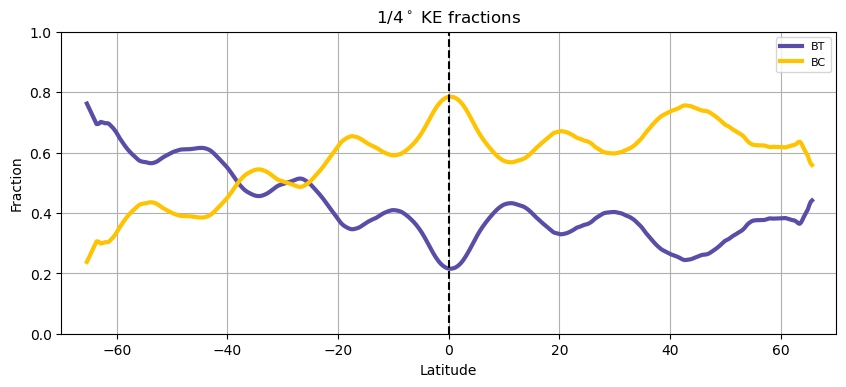

In [27]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BT_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.grid()
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BC_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-70, 70)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')

Text(0.5, 1.0, '1/16$^\\circ$ KE fractions')

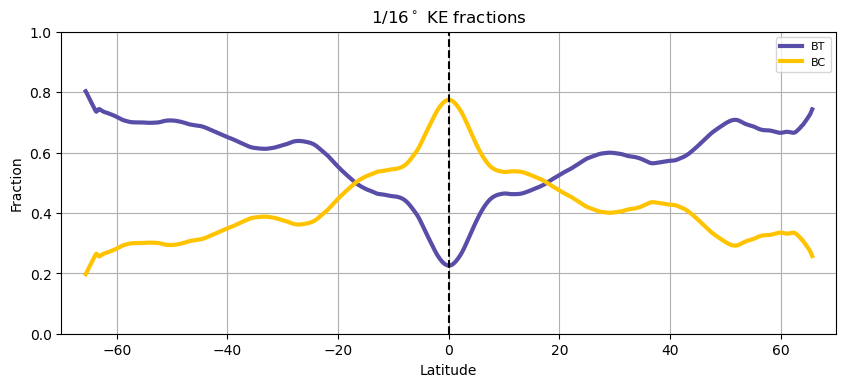

In [28]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=120

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BT_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.grid()
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BC_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-70, 70)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/16$^\circ$ KE fractions')

Text(0.5, 1.0, '1/4$^\\circ$ KE value')

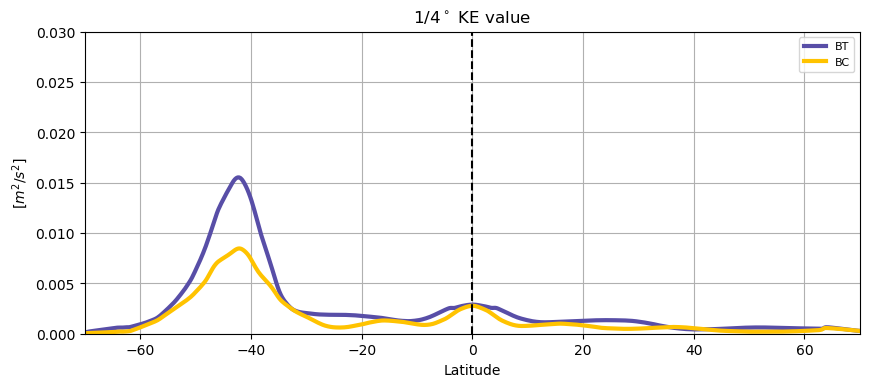

In [19]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(KE_BT_tot_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.grid()
plt.plot(yh_025,np.convolve(np.nanmean(KE_BC_tot_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-70, 70)
plt.ylim(0,0.03);
plt.xlabel('Latitude')
plt.ylabel('[$m^2/s^2$]')
plt.title('1/4$^\circ$ KE value')

Text(0.5, 1.0, '1/16$^\\circ$ KE value')

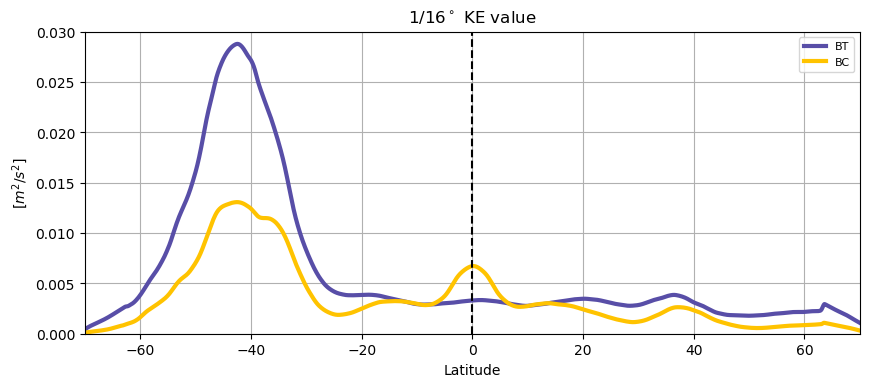

In [18]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=120

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(KE_BT_tot_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.grid()
plt.plot(yh_00625,np.convolve(np.nanmean(KE_BC_tot_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-70, 70)
plt.ylim(0,0.03);
plt.xlabel('Latitude')
plt.ylabel('[$m^2/s^2$]')
plt.title('1/16$^\circ$ KE value')

Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

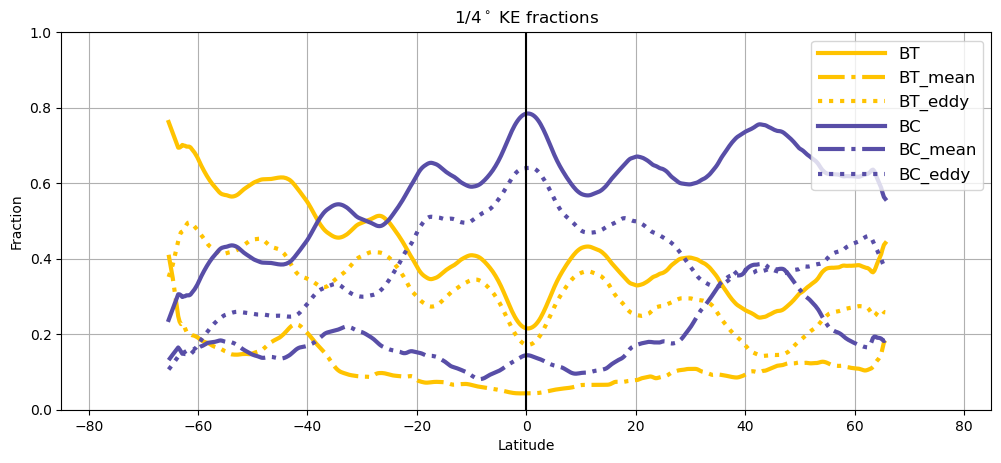

In [44]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BT_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BT_mean_025,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BT_eddy_025,axis=1), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BC_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BC_mean_025,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(fraction_BC_eddy_025,axis=1), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')

Text(0.5, 1.0, '1/16$^\\circ$ KE fractions')

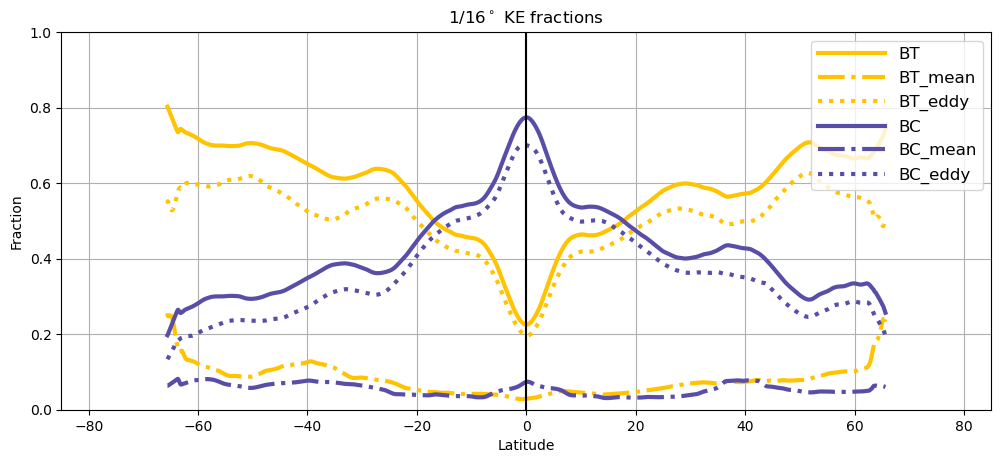

In [46]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=120

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BT_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BT_mean_00625,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BT_eddy_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BC_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BC_mean_00625,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(fraction_BC_eddy_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/16$^\circ$ KE fractions')

Text(0.5, 1.0, '1/4$^\\circ$ KE value')

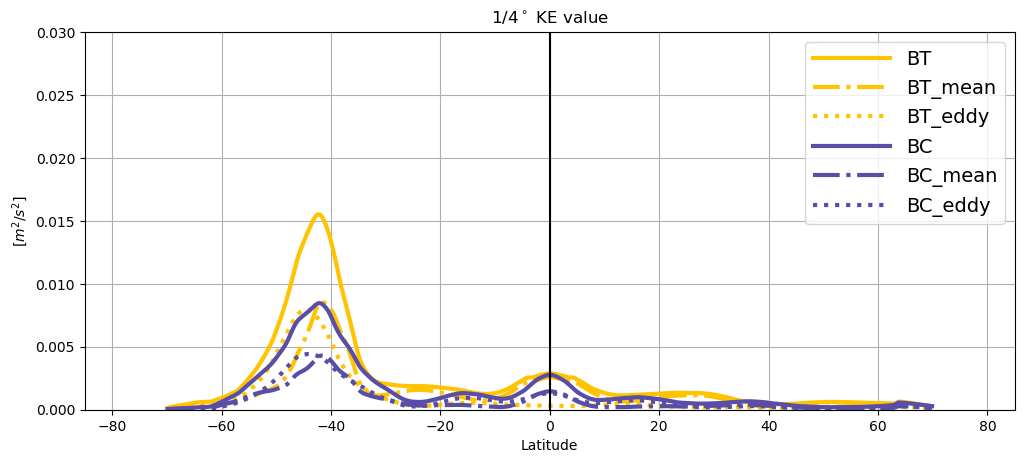

In [41]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(KE_BT_tot_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(KE_mean_BT_025,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(KE_eddy_BT_025,axis=1), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yh_025,np.convolve(np.nanmean(KE_BC_tot_025,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(KE_mean_BC_025,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yh_025,np.convolve(np.nanmean(KE_eddy_BC_025,axis=1), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=14,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,0.03);
plt.xlabel('Latitude')
plt.ylabel('[$m^2/s^2$]')
plt.title('1/4$^\circ$ KE value')

Text(0.5, 1.0, '1/16$^\\circ$ KE value')

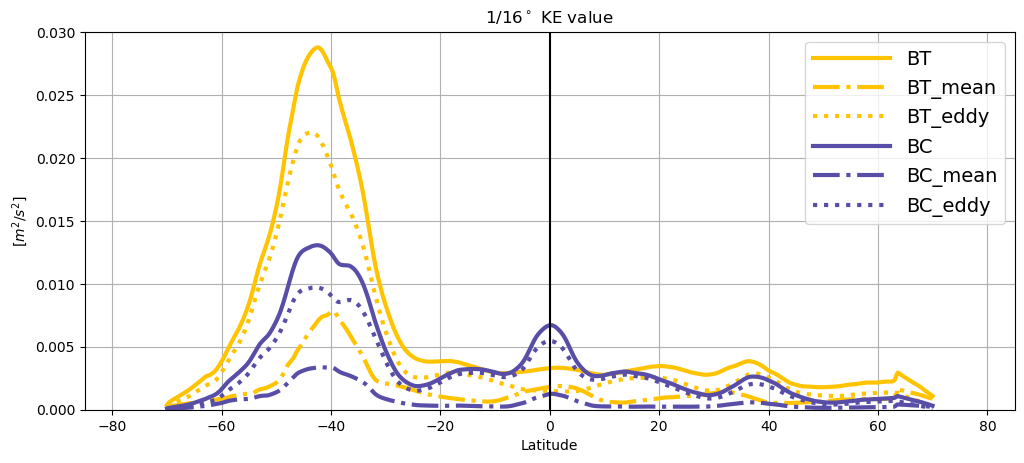

In [42]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=120

plt.figure(figsize=(12, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(KE_BT_tot_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(KE_mean_BT_00625,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(KE_eddy_BT_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
plt.grid()
plt.plot(yh_00625,np.convolve(np.nanmean(KE_BC_tot_00625,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(KE_mean_BC_00625,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yh_00625,np.convolve(np.nanmean(KE_eddy_BC_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=14,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,0.03);
plt.xlabel('Latitude')
plt.ylabel('[$m^2/s^2$]')
plt.title('1/16$^\circ$ KE value')